# Entregable 1
## Consigna

Desarrollar un script que extraiga datos de una API pública. A su vez, se debe crear una tabla en Redshift y cargar los datos extraídos.

In [16]:
import os

import pandas as pd
import redshift_connector
import requests
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from tabulate import tabulate

load_dotenv('.env')

True

### Extracción de datos

Para el siguiente trabajo se extrajeron los datos de [Alpha Vantage](https://www.alphavantage.co/) que proporciona datos del mercado financiero de nivel empresarial.

La extracción se realiza vía API y se toman los valores mensuales (último día de negociación de cada mes, apertura mensual, máximo mensual, mínimo mensual, cierre mensual, volumen mensual) de las acciones de IBM (IBM), APPLE (AAPL) y TESLA (TSLA), que cubre más de 20 años de datos históricos.

In [2]:
def extract_data(symbol):
    try:
        url = f'https://www.alphavantage.co/query?function=TIME_SERIES_MONTHLY&symbol={symbol}&apikey={os.getenv("API_KEY")}'
        response = requests.get(url)
        json_data = response.json()
        data = pd.DataFrame(json_data['Monthly Time Series'])
        data = data.T
        data['symbol'] = symbol
        
        return data

    except requests.exceptions.RequestException as e:
        print(f"Error de solicitud: {e}")
        return None

In [3]:
data_ibm = extract_data('IBM')
data_aapl = extract_data('AAPL')
data_tsla = extract_data('TSLA')
data = pd.concat([data_ibm, data_aapl, data_tsla], axis=0)

In [4]:
data.head()

,1. open,2. high,3. low,4. close,5. volume,symbol
2023-05-26,126.3500,129.6600,120.5500,128.8900,80883527,IBM
2023-04-28,130.9700,132.6100,124.5600,126.4100,83664114,IBM
2023-03-31,128.9000,131.4800,121.7100,131.0900,138093084,IBM
2023-02-28,134.4900,137.3900,128.8600,129.3000,76080679,IBM
2023-01-31,141.1000,147.1800,132.9800,134.7300,105576019,IBM


### Transformación de datos

In [5]:
def transform_data(data):
    data.rename(columns = {
        "1. open" : "open", 
        "2. high" : "high", 
        "3. low" : "low", 
        "4. close" : "close", 
        "5. volume" : "volume"
        }, inplace=True)
    
    for column in data[["open", "high", "low", "close", "volume"]]:
        data[column] = data[column].astype(float)

    data.reset_index(inplace=True)
    data.rename(columns={"index":"date"}, inplace=True)
    data.date = pd.to_datetime(data.date)

    return data

In [6]:
transformed_data = transform_data(data)

In [7]:
transformed_data.head()

,date,open,high,low,close,volume,symbol
0,2023-05-26,126.35,129.66,120.55,128.89,80883527.0,IBM
1,2023-04-28,130.97,132.61,124.56,126.41,83664114.0,IBM
2,2023-03-31,128.90,131.48,121.71,131.09,138093084.0,IBM
3,2023-02-28,134.49,137.39,128.86,129.30,76080679.0,IBM
4,2023-01-31,141.10,147.18,132.98,134.73,105576019.0,IBM


In [8]:
symbol_list = transformed_data.symbol.unique().tolist()
symbol_list

['IBM', 'AAPL', 'TSLA']

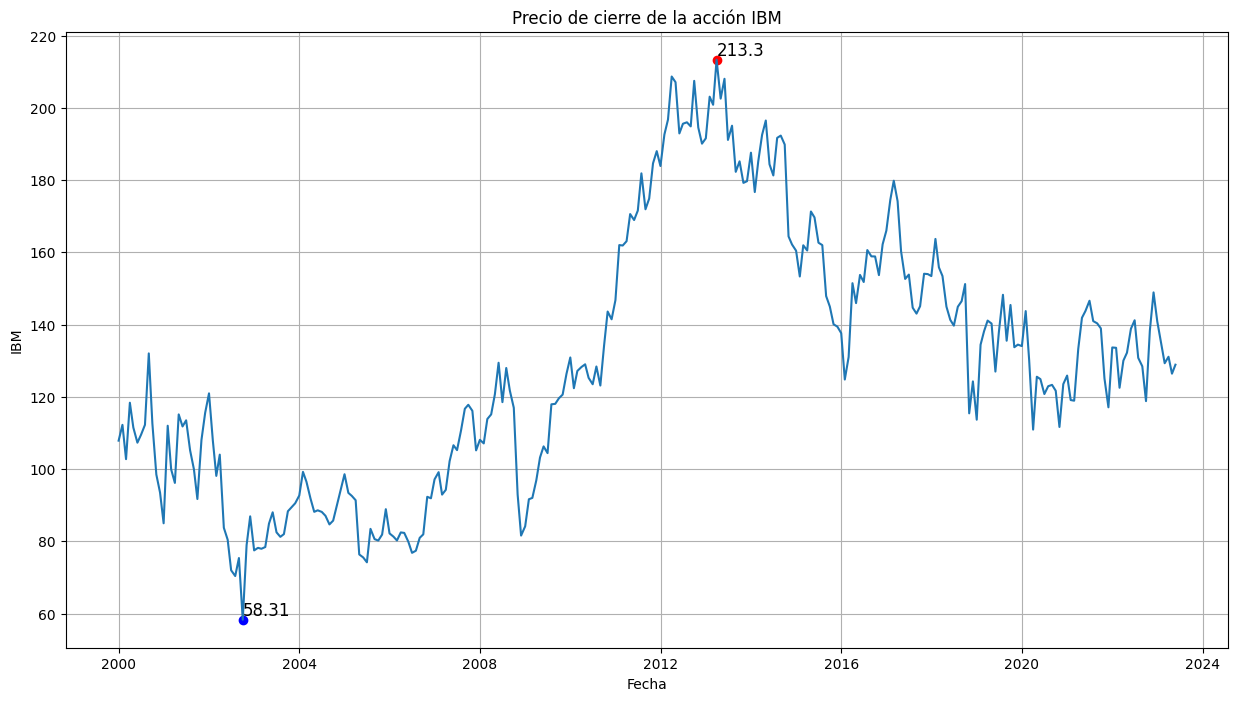

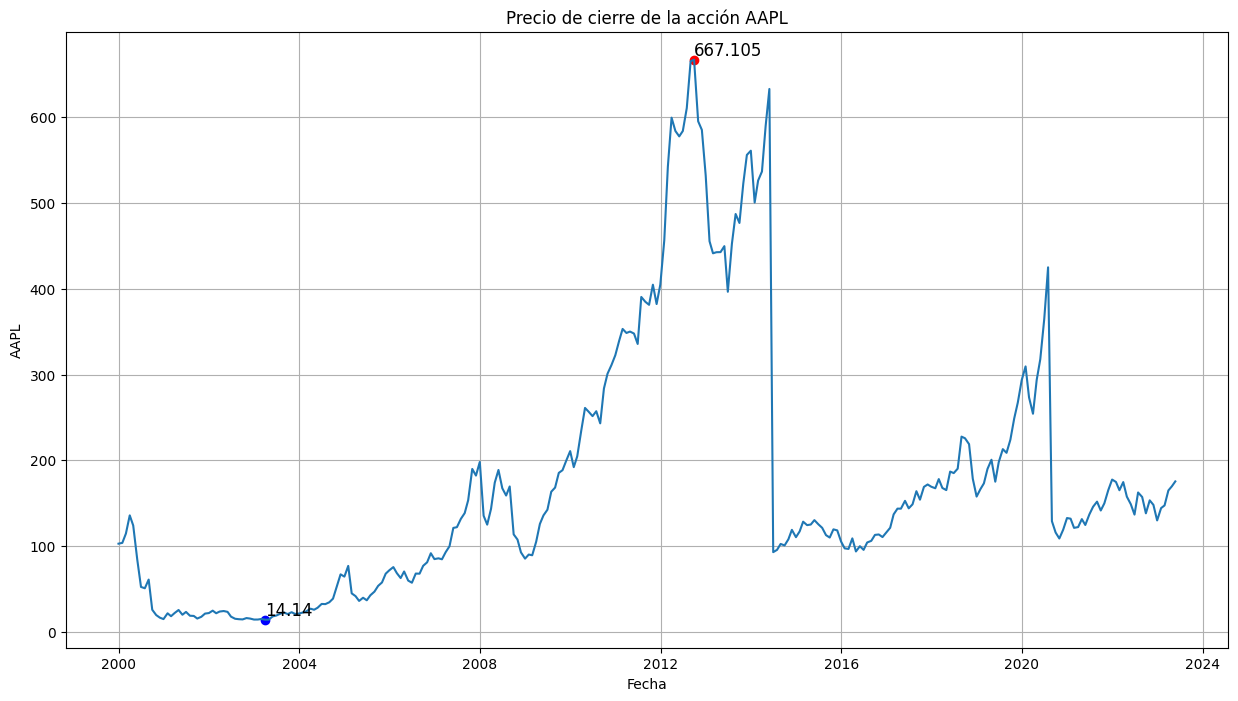

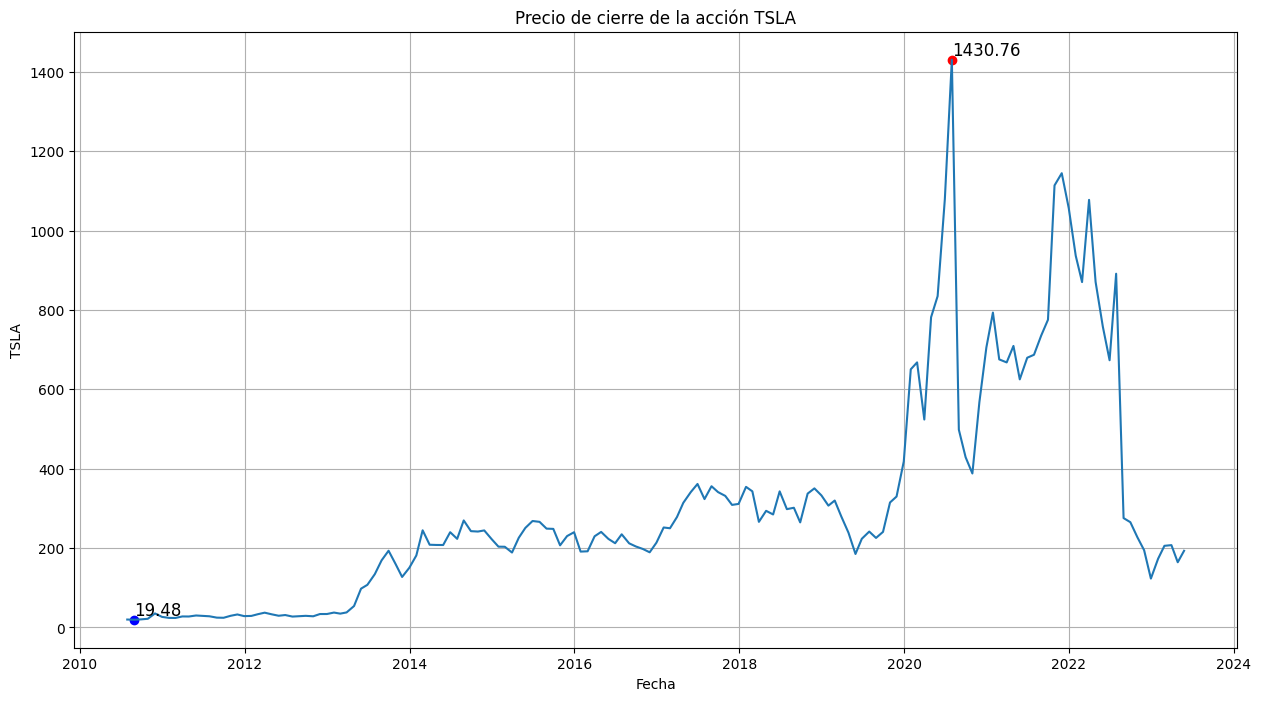

In [9]:
for symbol in symbol_list:
    plt.figure(figsize=(15, 8))
    
    x = transformed_data[transformed_data.symbol == symbol]["date"]
    y = transformed_data[transformed_data.symbol == symbol]["close"]

    # Plot lists 'x' and 'y'
    plt.plot(x, y)
    
    indice_maximo = y.idxmax()
    indice_minimo = y.idxmin()

    plt.scatter(x[indice_maximo], y[indice_maximo], color='red', label='Máximo')
    plt.scatter(x[indice_minimo], y[indice_minimo], color='blue', label='Mínimo')
    
    plt.text(x[indice_maximo], y[indice_maximo], str(y[indice_maximo]), ha='left', va='bottom', fontsize=12)
    plt.text(x[indice_minimo], y[indice_minimo], str(y[indice_minimo]), ha='left', va='bottom', fontsize=12)

    # Plot axes labels and show the plot
    plt.title(f'Precio de cierre de la acción {symbol}')
    plt.xlabel('Fecha')
    plt.ylabel(symbol)
    plt.grid()

    plt.show()

### Carga de datos

In [17]:
def load_data(data):
    # Nombre de la tabla y esquema
    tabla = "finance_ibm"
    esquema = "aguyanzon_coderhouse"

    # Crea la conexión a Redshif
    print("Conectando a Redshift...")
    conn = redshift_connector.connect(
        host=os.getenv("REDSHIFT_HOST"),
        port=int(os.getenv("REDSHIFT_PORT")),
        database=os.getenv("REDSHIFT_DATABASE"),
        user=os.getenv("REDSHIFT_USER"),
        password=os.getenv("REDSHIFT_PASSWORD")
    )
    print('Conexion a Redshift creada...')

    # Crea la tabla en el esquema especificado
    create_table_query = f'''
        CREATE TABLE IF NOT EXISTS {esquema}.{tabla} (
            "date" DATE distkey,
            "open" VARCHAR(255),
            high VARCHAR(255),
            low VARCHAR(255),
            close VARCHAR(255), 
            volume VARCHAR(255),
            symbol VARCHAR(255)
        ) sortkey(date);
    '''

    with conn.cursor() as cursor:
        print(f"Creando tabla {tabla}")
        cursor.execute(create_table_query)
        print(f"Insertando datos...")
        for index, row in data.iterrows():
            cursor.execute(
                f'''INSERT INTO {esquema}.{tabla} ("date", "open", high, low, close, volume, symbol) VALUES (%s, %s, %s, %s, %s, %s, %s)''',
                (row['date'], row['open'], row['high'], row['low'], row['close'], row['volume'], row['symbol'])
            )
        cursor.execute(f"SELECT * FROM {esquema}.{tabla} LIMIT 10")
        results = cursor.fetchall()

        column_names = [desc[0] for desc in cursor.description]
        table = tabulate(results, headers=column_names, tablefmt='psql')
        print(table)
    conn.commit()

    # Cierra la conexión a Redshift
    conn.close()

In [18]:
load_data(transformed_data)

Conectando a Redshift...
Conexion a Redshift creada...
Creando tabla finance_ibm
Insertando datos...
+------------+--------+---------+---------+---------+-----------+----------+
| date       |   open |    high |     low |   close |    volume | symbol   |
|------------+--------+---------+---------+---------+-----------+----------|
| 2023-05-26 | 126.35 | 129.66  | 120.55  |  128.89 |  80883527 | IBM      |
| 2023-04-28 | 130.97 | 132.61  | 124.56  |  126.41 |  83664114 | IBM      |
| 2023-03-31 | 128.9  | 131.48  | 121.71  |  131.09 | 138093084 | IBM      |
| 2023-02-28 | 134.49 | 137.39  | 128.86  |  129.3  |  76080679 | IBM      |
| 2023-01-31 | 141.1  | 147.18  | 132.98  |  134.73 | 105576019 | IBM      |
| 2022-12-30 | 149.98 | 153.21  | 137.195 |  140.89 |  86426226 | IBM      |
| 2022-11-30 | 138.25 | 150.46  | 133.97  |  148.9  |  93620235 | IBM      |
| 2022-10-31 | 120.16 | 138.862 | 115.545 |  138.29 | 113480787 | IBM      |
| 2022-09-30 | 128.4  | 130.99  | 118.61  |  118.81 